<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57428 entries, 0 to 57427
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   HITId      6020 non-null   float64
 1   tweet      57428 non-null  object 
 2   sentiment  57428 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.3+ MB
None
       HITId                                              tweet sentiment
0        1.0             call sis im boy girl still faggot shut         1
1        2.0                           legit nilas retarded idk         0
2        3.0                                        said retard         1
3        4.0  america another years obamas ideology via hill...         1
4        5.0                          don fucking made cry twat         1
...      ...                                                ...       ...
57423    NaN  and for the second time of asking when your vi...         0
57424    NaN  you should be ashamed of your

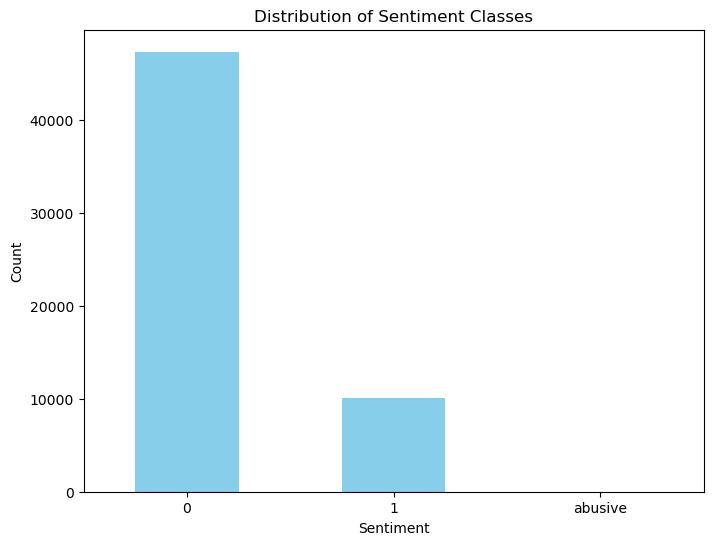

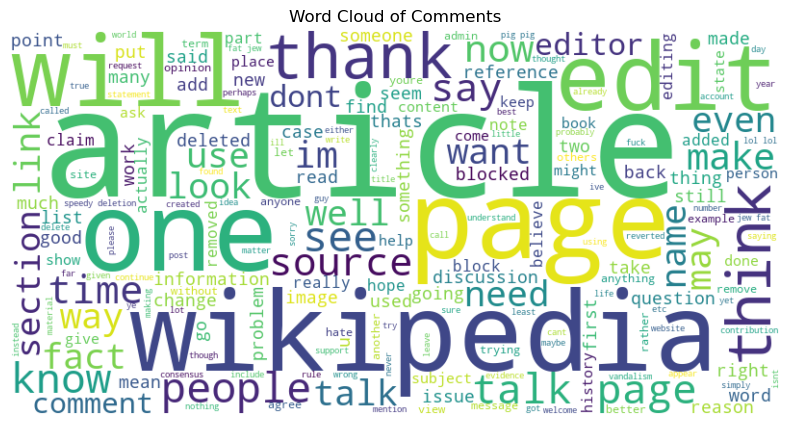

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

comments = pd.read_csv('en_harmful_comment_dataset.csv', delimiter=';')
print(comments.info())


def remove_special_characters(text):
    # Remove special characters, symbols, and emojis using regex
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    return cleaned_text

def remove_urls(text):
    # Remove URLs from the text using regex
    cleaned_text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    return cleaned_text

def remove_numbers(text):
    # Remove numbers from the text using regex
    cleaned_text = re.sub(r'\d+', '', text)
    return cleaned_text

def remove_mentions(text):
    # Remove mentions/handles (e.g., @username) from the text using regex
    cleaned_text = re.sub(r'@\w+', '', text)
    return cleaned_text

def process_comment(comment):
    processed_comment = comment.lower()
    # Remove special characters, symbols, and emojis
    processed_comment = remove_special_characters(processed_comment)
    # Remove URLs
    processed_comment = remove_urls(processed_comment)
    # Remove numbers
    processed_comment = remove_numbers(processed_comment)
    # Remove mentions/handles
    processed_comment = remove_mentions(processed_comment)

    # Split the text into words
    words = processed_comment.split()
    
    # Filter out words "user" and "url"
    filtered_words = [word for word in words if word not in ['user', 'url']]
    
    # Join the filtered words back into a sentence
    processed_comment = ' '.join(filtered_words)
    
    return processed_comment

comments.dropna(subset=['tweet'], inplace=True)
comments.dropna(subset=['tweet'], inplace=True)
# Process the comments
comments['tweet'] = comments['tweet'].apply(process_comment)
print(comments)

# Data Visualization
plt.figure(figsize=(8, 6))
comments['sentiment'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Word Cloud
all_comments = ' '.join(comments['tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split  # Add this import
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

z = comments['tweet']
y = comments["sentiment"]

# Encode the target labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into train and test sets
z_train, z_test, y_train, y_test = train_test_split(z, y, test_size=0.2)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
features_train = tfidf_vectorizer.fit_transform(z_train).toarray()
features_test = tfidf_vectorizer.transform(z_test).toarray()

# Convert the data to PyTorch tensors
X_train = torch.tensor(features_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(features_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
input_dim = features_train.shape[1]
print(input_dim)
hidden_dim = 20  
output_dim = len(label_encoder.classes_)  # Number of classes in your dataset
print(output_dim)

# Initialize the model
model = NeuralNetwork(input_dim, hidden_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of training epochs and batch size
num_epochs = 10
batch_size = 32

# Create DataLoader for the training data
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

# Evaluation on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test).argmax(dim=1)
    test_accuracy = torch.sum(y_pred == y_test).item() / len(y_test)
    print(f"Test Accuracy: {test_accuracy}")

# Additional evaluation metrics
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred)
print("Classification Report:")
print(classification_report(y_test_original, y_pred_original, zero_division=1))  

print("Confusion Matrix:")
print(confusion_matrix(y_test_original, y_pred_original))


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


95236
3
Epoch 1/10, Loss: 0.33444856856962596
Epoch 2/10, Loss: 0.14871891462672138
Epoch 3/10, Loss: 0.09821952224649427
Epoch 4/10, Loss: 0.06713768262607447
Epoch 5/10, Loss: 0.04704439798275963
Epoch 6/10, Loss: 0.03445152573680348
Epoch 7/10, Loss: 0.02598202917508393
Epoch 8/10, Loss: 0.02024750772316896
Epoch 9/10, Loss: 0.01647020648413262
Epoch 10/10, Loss: 0.013499804591287568
Test Accuracy: 0.9020546752568344
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      9505
           1       0.74      0.67      0.70      1980
     abusive       1.00      0.00      0.00         1

    accuracy                           0.90     11486
   macro avg       0.89      0.54      0.55     11486
weighted avg       0.90      0.90      0.90     11486

Confusion Matrix:
[[9039  466    0]
 [ 658 1322    0]
 [   0    1    0]]


In [3]:
import joblib

# Save the model using torch.save()
model_filename = 'best_mlp_model'
torch.save(model.state_dict(), model_filename)

# Save the TF-IDF vectorizer using joblib
tfidf_vectorizer_filename = 'tfidf_vectorizer.joblib'
joblib.dump(tfidf_vectorizer, tfidf_vectorizer_filename)

['tfidf_vectorizer.joblib']

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the new dataset (e.g., test.csv)
new_data = pd.read_csv('test.csv', delimiter=';')
new_tweets = new_data['tweet']

# Preprocess the new dataset using the same TF-IDF vectorizer
new_features = tfidf_vectorizer.transform(new_tweets).toarray()

# Convert the data to PyTorch tensors
X_new = torch.tensor(new_features, dtype=torch.float32)

# Make predictions using the model
model.eval()
with torch.no_grad():
    y_pred_new = model(X_new).argmax(dim=1)

# Convert the predicted labels back to their original labels
y_pred_original_new = label_encoder.inverse_transform(y_pred_new)

# Create a new DataFrame with the 'tweet' and 'prediction' columns
submission_df = pd.DataFrame({'tweet': new_tweets, 'prediction': y_pred_original_new})

# Save the predictions to a CSV file
submission_df.to_csv("submission.csv", index=False)
